#### Importing Necessary Libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as TrainTestSplitter

from tabulate import tabulate

#### Defining Constants

In [2]:
pi = np.pi

#### Performing Regression and Prediction

In [3]:
def performReg(desiredDeg, trainData, testData, trainLabel):
    polyReg = Pipeline([
            ("std_scaler", StandardScaler()),
            ("poly_features", PolynomialFeatures(degree=desiredDeg, include_bias=True)),
            ("lin_reg", LinearRegression()),
        ])
    polyReg.fit(trainData, trainLabel)
    modelPred = polyReg.predict(testData)
    
    return modelPred, polyReg

#### Plotting

In [4]:
def performPlot(x, y, xMin, xMax, yMin, yMax, xLabel, yLabel, plotTitle, plotColor, shape):
    plt.plot(x, y, shape ,color =plotColor)
    plt.xlabel(xLabel, fontsize=18)
    plt.ylabel(yLabel, rotation=90, fontsize=18)
    plt.axis([xMin, xMax, yMin, yMax])
    plt.grid()
    plt.title(plotTitle)

#### Regression for Multiple Dgrees 

In [5]:
def regAndPlot(degrees, trainData, testData, trainLabel):
    
    xLabel = 'Input Data'
    yLabel = 'Output Data'
    plotTitle = 'Regression with Degree = '
    
    modelPreds = []
    models = []
    for degree in degrees:
        modelPred, model = performReg(degree, trainData, testData, trainLabel)
        modelPreds.append(modelPred)
        models.append(model)
        
        performPlot(trainData, trainLabel, -3, 3, -5, 5, xLabel, yLabel, plotTitle + str(degree),
                    'mediumpurple', '.')
        performPlot(testData, modelPred, -3, 3, -5, 5, xLabel, yLabel, plotTitle + str(degree),
                    'indigo', '.')
        plt.show()
    
    return modelPreds, models

#### MSE Calculation

In [6]:
def calcMSE(actualModel, predictedModel):
    return MSE(actualModel, predictedModel)

def calcMSEs(actualModel, predictedModels, degrees):
    allMSEs = []
    
    for degree in degrees:
        loopMSE = calcMSE(actualModel, predictedModels[degrees.index(degree)])
        allMSEs.append(loopMSE)
    
    return allMSEs

#### Print Table

In [7]:
def plotTable(clmData1, clmData2):
    data = []
    for i in range(len(clmData1)):
        data.append([clmData1[i], '{:1.4f}'.format(clmData2[i])])
        
    print(tabulate(data, headers=['Degrees', 'MSEs'], tablefmt="fancy_grid", 
                   colalign=("center",)))

#### Employing the Above Functions

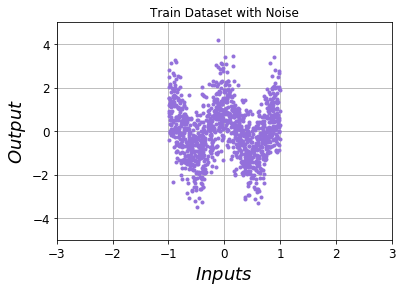

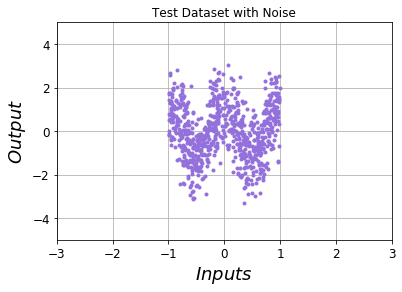

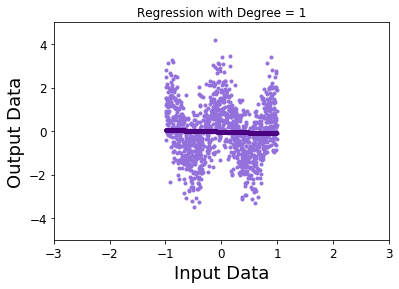

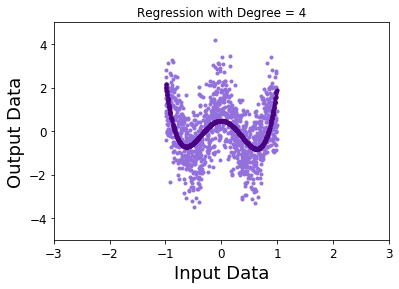

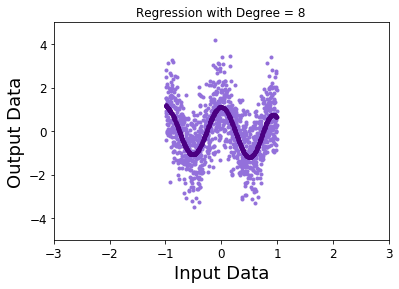

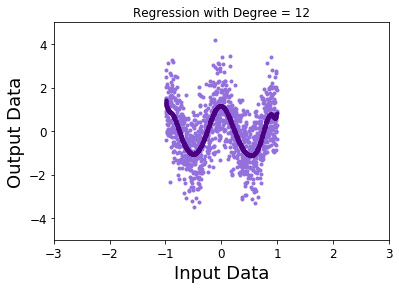

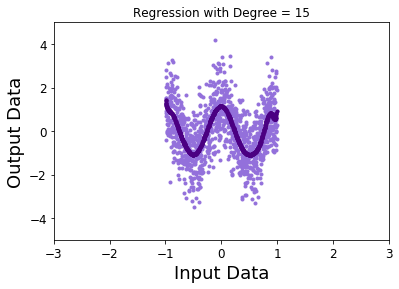

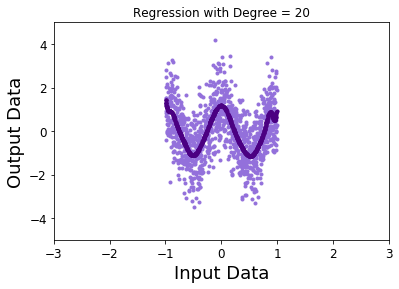

╒═══════════╤════════╕
│  Degrees  │   MSEs │
╞═══════════╪════════╡
│     1     │ 1.5003 │
├───────────┼────────┤
│     4     │ 1.1448 │
├───────────┼────────┤
│     8     │ 0.9639 │
├───────────┼────────┤
│    12     │ 0.965  │
├───────────┼────────┤
│    15     │ 0.9635 │
├───────────┼────────┤
│    20     │ 0.9708 │
╘═══════════╧════════╛


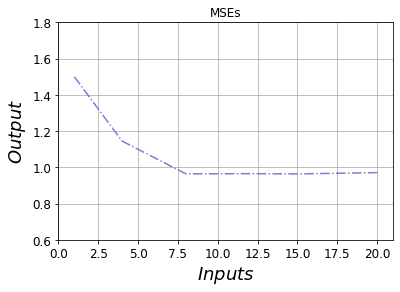

In [8]:
dataLen = 2000
#Simulating cosines for train dataset:
# x = np.random.rand(dataLen,1) * 4 - 2   ##For higher degree
x = np.random.rand(dataLen,1) * 2 - 1    ##For lower degree
arg = x * 2 * pi
myCosines = np.cos(arg)
#Adding zero mean and unite variance normal noise to consines:
noise = np.random.randn(dataLen,1)
y = myCosines + noise
#Splitting data into train and test datasets:
trainData, testData, trainLabel, testLabel = TrainTestSplitter(x, y, 
                                                            test_size=int(len(y)* 0.4), 
                                                            random_state=100)
#Plotting the train dataset to gain insight:
performPlot(trainData, trainLabel, -3, 3, -5, 5, '$Inputs$', "$Output$",
            'Train Dataset with Noise', 'mediumpurple', '.')
plt.show()

#Plotting the test dataset to gain insight:
performPlot(testData, testLabel, -3, 3, -5, 5, '$Inputs$', "$Output$",
            'Test Dataset with Noise', 'mediumpurple', '.')
plt.show()

#Performing regression for various degrees and plotting each one:
degrees = [1, 4, 8, 12, 15, 20]
modelPreds, models = regAndPlot(degrees, trainData, testData, trainLabel)
#Calculating MSE for each degree and plotting the calculations:
allMSEs = calcMSEs(testLabel, modelPreds, degrees)
plotTable(degrees, allMSEs)
performPlot(degrees, allMSEs, 0, 21, 0.6, 1.8,
            '$Inputs$', "$Output$", 'MSEs', 'mediumpurple', '-.')
plt.show()


#### Bias and Variance Calculation

#### Generating New Data

In [9]:
myCosineFunc = lambda x : np.cos(2*pi*(x.flatten()))
def genNewData(numSamples, numRepeat):
    X = np.random.rand(numSamples) * 4 - 2
    X = np.sort(X)
    
    if not numRepeat == 1:
        y = np.zeros((numSamples, numRepeat))
        for i in range(numRepeat):
            y[:, i] = myCosineFunc(X) + np.random.randn(numSamples)   
    else:
        y = myCosineFunc(X) + np.random.randn(numSamples)
        
    X = X.reshape((numSamples, 1))
    
    return X,y

#### Fit and Predict Labels

In [10]:
def fitScaler(numRepeat, deg, trainData, trainLabel, testData, predLabel):
    for num in range(numRepeat):
        polyReg = Pipeline([("std_scaler", StandardScaler()),
                            ("poly_features", PolynomialFeatures(degree=deg, include_bias=True)),
                            ("lin_reg", LinearRegression()),])
    
        polyReg.fit(trainData[num], trainLabel[num])
        predLabel[:,num] = polyReg.predict(testData)
    return predLabel

#### Error Computation of Labels

In [11]:
def labeErrEsti(numTest, numRepeat, testLabel, predLabel):
    labelErr = np.zeros(numTest)

    for i in range(numRepeat):
        for j in range(numRepeat):
            labelErr += (testLabel[:,j]-predLabel[:,i]) ** 2
            
    labelErr /= numRepeat**2
    
    return labelErr

#### Plotting Beautiful Table :)

In [12]:
def plotTable(clmData1, clmData2, clmData3, clmData4, clmData5):
    data = []
    for i in range(len(clmData1)):
        data.append([clmData1[i], '{:1.4f}'.format(clmData2[i]), 
                     '{:1.4f}'.format(clmData3[i]), '{:1.4f}'.format(clmData4[i])
                    , '{:1.4f}'.format(clmData5[i])])
        
    print(tabulate(data, headers=['Degrees', 'MSEs', 'Noise Var', 'Bias^2', 'Model Var'], tablefmt="fancy_grid", 
                   colalign=("center",)))
    

#### Employing Above Functions

In [13]:
numRepeat = 500
numTrain = 500
numTest = 1000
np.random.seed(0)

trainData, trainLabel = [], []
for i in range(numRepeat):
    X, y = genNewData(numTrain, 1)
    trainData.append(X)
    trainLabel.append(y)
    
testData, testLabel = genNewData(numTest, numRepeat)
degrees = [1, 4, 8, 12, 15, 20]
labelsErr, labelsNoise, labelsBias2, labelsVar = np.zeros((6,1)), np.zeros((6,1)), np.zeros((6,1)), np.zeros((6,1))

for n in range(6):
    predLabel = np.zeros((numTest, numRepeat))
    predLabel = fitScaler(numRepeat, degrees[n], trainData, trainLabel, 
                          testData, predLabel)
    
    labelsErr[n,:] = np.mean(labeErrEsti(numTest, numRepeat, testLabel, predLabel))
    labelsNoise[n,:] = np.mean(np.var(testLabel, axis=1))
    labelsBias2[n,:] = np.mean((myCosineFunc(testData)-np.mean(predLabel, axis=1))** 2)
    labelsVar[n,:] = np.mean(np.var(predLabel, axis=1))
    

In [14]:
plotTable(degrees, labelsErr.flatten().tolist(), labelsNoise.flatten().tolist(), labelsBias2.flatten().tolist(), labelsVar.flatten().tolist())


╒═══════════╤════════╤═════════════╤══════════╤═════════════╕
│  Degrees  │   MSEs │   Noise Var │   Bias^2 │   Model Var │
╞═══════════╪════════╪═════════════╪══════════╪═════════════╡
│     1     │ 1.5038 │      0.9995 │   0.498  │      0.0059 │
├───────────┼────────┼─────────────┼──────────┼─────────────┤
│     4     │ 1.4785 │      0.9995 │   0.4655 │      0.0136 │
├───────────┼────────┼─────────────┼──────────┼─────────────┤
│     8     │ 1.3991 │      0.9995 │   0.3752 │      0.0243 │
├───────────┼────────┼─────────────┼──────────┼─────────────┤
│    12     │ 1.0481 │      0.9995 │   0.0183 │      0.0291 │
├───────────┼────────┼─────────────┼──────────┼─────────────┤
│    15     │ 1.039  │      0.9995 │   0.0011 │      0.0366 │
├───────────┼────────┼─────────────┼──────────┼─────────────┤
│    20     │ 1.0595 │      0.9995 │   0.0001 │      0.0581 │
╘═══════════╧════════╧═════════════╧══════════╧═════════════╛
